In [3]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [4]:
%matplotlib inline
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

#fig = plt.figure(figsize = (12, 12)) 
#ax = fig.add_subplot(111)
#visualize_input(X_train[0], ax)

In [5]:
# Preprocessing

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [6]:
def make_trainable(network, val):
    network.trainable = val
    #for l in network.layers:
        #l.trainable = val

In [7]:
# Set the dimensions of the noise
z_dim = 100

In [8]:
g = Sequential()
g.add(Dense(128, input_shape=(z_dim, ), activation=LeakyReLU(alpha=0.01)))
g.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.01)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1

optimizer = Adam(lr=0.001)
g.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

d = Sequential()
d.add(Dense(1024, input_shape=(784, ), activation=LeakyReLU(alpha=0.01)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.01)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
d.add(Dropout(0.3))
d.add(Dense(128, activation=LeakyReLU(alpha=0.01)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1

optimizer = Adam(lr=0.002)
d.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

d.trainable = False
input = Input(shape=(z_dim, ))
hidden = g(input)
output = d(hidden)
gan = Model(input, output)

optimizer = RMSprop(lr=0.002)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    d_acc = [v[1] for v in losses["D"]]
    g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.plot(d_acc, label="Discriminator accuracy")
    plt.plot(g_acc, label="Generator accuracy")
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=6, dim=(1, 6), figsize=(10, 7)):
    noise = np.random.uniform(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(epochs), leave=False):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm_notebook(range(batchCount)):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros([2 * BATCH_SIZE])
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            make_trainable(d, True)
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones([BATCH_SIZE])
            make_trainable(d, False)
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 0 or e%plt_frq == plt_frq - 1:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 0 ---------------


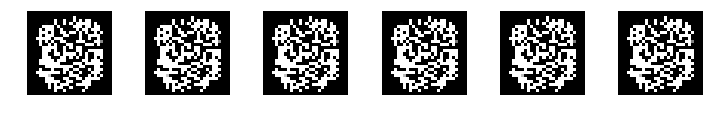

--------------- Epoch 1 ---------------


--------------- Epoch 2 ---------------


--------------- Epoch 3 ---------------


--------------- Epoch 4 ---------------


--------------- Epoch 5 ---------------


--------------- Epoch 6 ---------------


--------------- Epoch 7 ---------------


--------------- Epoch 8 ---------------


--------------- Epoch 9 ---------------


--------------- Epoch 10 ---------------


--------------- Epoch 11 ---------------


--------------- Epoch 12 ---------------


--------------- Epoch 13 ---------------


--------------- Epoch 14 ---------------


--------------- Epoch 15 ---------------


--------------- Epoch 16 ---------------


--------------- Epoch 17 ---------------


--------------- Epoch 18 ---------------


--------------- Epoch 19 ---------------


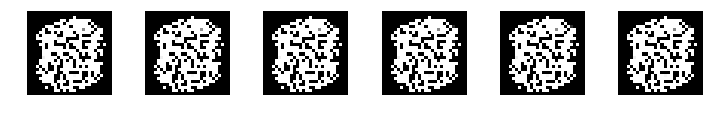

--------------- Epoch 20 ---------------


--------------- Epoch 21 ---------------


--------------- Epoch 22 ---------------


--------------- Epoch 23 ---------------


--------------- Epoch 24 ---------------


--------------- Epoch 25 ---------------


--------------- Epoch 26 ---------------


--------------- Epoch 27 ---------------


--------------- Epoch 28 ---------------


--------------- Epoch 29 ---------------


--------------- Epoch 30 ---------------


--------------- Epoch 31 ---------------


--------------- Epoch 32 ---------------


--------------- Epoch 33 ---------------


--------------- Epoch 34 ---------------


--------------- Epoch 35 ---------------


--------------- Epoch 36 ---------------


--------------- Epoch 37 ---------------


--------------- Epoch 38 ---------------


--------------- Epoch 39 ---------------


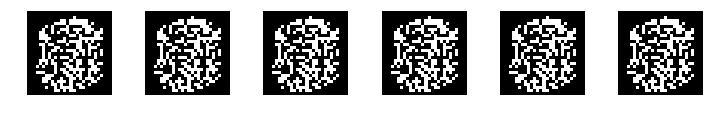

--------------- Epoch 40 ---------------


--------------- Epoch 41 ---------------


--------------- Epoch 42 ---------------


--------------- Epoch 43 ---------------


--------------- Epoch 44 ---------------


--------------- Epoch 45 ---------------


--------------- Epoch 46 ---------------


--------------- Epoch 47 ---------------


--------------- Epoch 48 ---------------


--------------- Epoch 49 ---------------


--------------- Epoch 50 ---------------


--------------- Epoch 51 ---------------


--------------- Epoch 52 ---------------


--------------- Epoch 53 ---------------


--------------- Epoch 54 ---------------


--------------- Epoch 55 ---------------


--------------- Epoch 56 ---------------


--------------- Epoch 57 ---------------


--------------- Epoch 58 ---------------


--------------- Epoch 59 ---------------


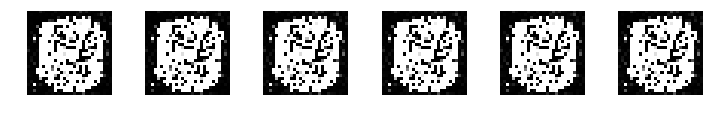

--------------- Epoch 60 ---------------


--------------- Epoch 61 ---------------


--------------- Epoch 62 ---------------


--------------- Epoch 63 ---------------


--------------- Epoch 64 ---------------


--------------- Epoch 65 ---------------


--------------- Epoch 66 ---------------


--------------- Epoch 67 ---------------


--------------- Epoch 68 ---------------


--------------- Epoch 69 ---------------


--------------- Epoch 70 ---------------


--------------- Epoch 71 ---------------


--------------- Epoch 72 ---------------


--------------- Epoch 73 ---------------


--------------- Epoch 74 ---------------


--------------- Epoch 75 ---------------


--------------- Epoch 76 ---------------


--------------- Epoch 77 ---------------


--------------- Epoch 78 ---------------


--------------- Epoch 79 ---------------


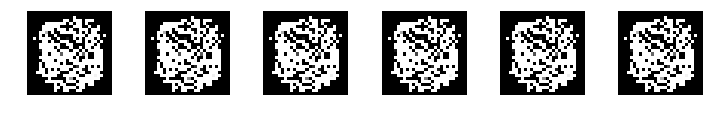

--------------- Epoch 80 ---------------


--------------- Epoch 81 ---------------


--------------- Epoch 82 ---------------


--------------- Epoch 83 ---------------


--------------- Epoch 84 ---------------


--------------- Epoch 85 ---------------


--------------- Epoch 86 ---------------


--------------- Epoch 87 ---------------


--------------- Epoch 88 ---------------


--------------- Epoch 89 ---------------


--------------- Epoch 90 ---------------


--------------- Epoch 91 ---------------


--------------- Epoch 92 ---------------


--------------- Epoch 93 ---------------


--------------- Epoch 94 ---------------


--------------- Epoch 95 ---------------


--------------- Epoch 96 ---------------


--------------- Epoch 97 ---------------


--------------- Epoch 98 ---------------


--------------- Epoch 99 ---------------


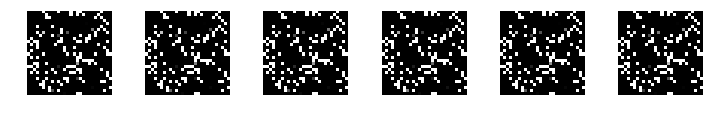

--------------- Epoch 100 ---------------


--------------- Epoch 101 ---------------


--------------- Epoch 102 ---------------


--------------- Epoch 103 ---------------


--------------- Epoch 104 ---------------


--------------- Epoch 105 ---------------


--------------- Epoch 106 ---------------


--------------- Epoch 107 ---------------


--------------- Epoch 108 ---------------


--------------- Epoch 109 ---------------


--------------- Epoch 110 ---------------


--------------- Epoch 111 ---------------


--------------- Epoch 112 ---------------


--------------- Epoch 113 ---------------


--------------- Epoch 114 ---------------


--------------- Epoch 115 ---------------


--------------- Epoch 116 ---------------


--------------- Epoch 117 ---------------


--------------- Epoch 118 ---------------


--------------- Epoch 119 ---------------


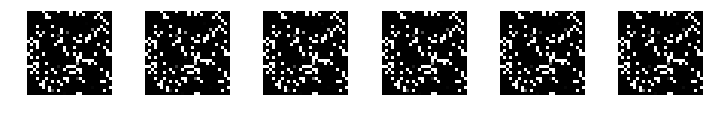

--------------- Epoch 120 ---------------


--------------- Epoch 121 ---------------


--------------- Epoch 122 ---------------


--------------- Epoch 123 ---------------


--------------- Epoch 124 ---------------


--------------- Epoch 125 ---------------


--------------- Epoch 126 ---------------


--------------- Epoch 127 ---------------


--------------- Epoch 128 ---------------


--------------- Epoch 129 ---------------


--------------- Epoch 130 ---------------


--------------- Epoch 131 ---------------


--------------- Epoch 132 ---------------


--------------- Epoch 133 ---------------


--------------- Epoch 134 ---------------


--------------- Epoch 135 ---------------


--------------- Epoch 136 ---------------


--------------- Epoch 137 ---------------


--------------- Epoch 138 ---------------


--------------- Epoch 139 ---------------


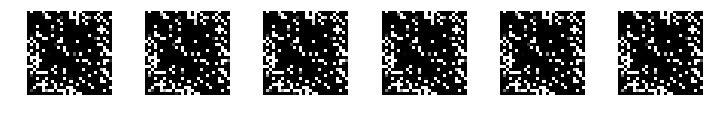

--------------- Epoch 140 ---------------


--------------- Epoch 141 ---------------


--------------- Epoch 142 ---------------


--------------- Epoch 143 ---------------


--------------- Epoch 144 ---------------


--------------- Epoch 145 ---------------


--------------- Epoch 146 ---------------


--------------- Epoch 147 ---------------


--------------- Epoch 148 ---------------


--------------- Epoch 149 ---------------


--------------- Epoch 150 ---------------


--------------- Epoch 151 ---------------


--------------- Epoch 152 ---------------


--------------- Epoch 153 ---------------


--------------- Epoch 154 ---------------


--------------- Epoch 155 ---------------


--------------- Epoch 156 ---------------


--------------- Epoch 157 ---------------


--------------- Epoch 158 ---------------


--------------- Epoch 159 ---------------


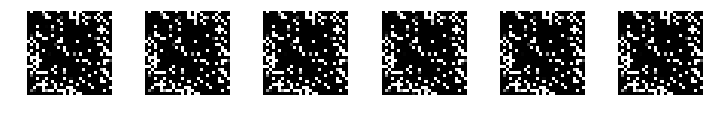

--------------- Epoch 160 ---------------


--------------- Epoch 161 ---------------


--------------- Epoch 162 ---------------


--------------- Epoch 163 ---------------


--------------- Epoch 164 ---------------


--------------- Epoch 165 ---------------


--------------- Epoch 166 ---------------


--------------- Epoch 167 ---------------


--------------- Epoch 168 ---------------


--------------- Epoch 169 ---------------


--------------- Epoch 170 ---------------


--------------- Epoch 171 ---------------


--------------- Epoch 172 ---------------


--------------- Epoch 173 ---------------


--------------- Epoch 174 ---------------


--------------- Epoch 175 ---------------


--------------- Epoch 176 ---------------


--------------- Epoch 177 ---------------


--------------- Epoch 178 ---------------


--------------- Epoch 179 ---------------


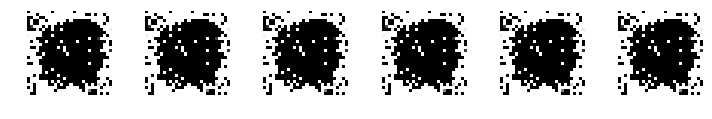

--------------- Epoch 180 ---------------


--------------- Epoch 181 ---------------


--------------- Epoch 182 ---------------


--------------- Epoch 183 ---------------


--------------- Epoch 184 ---------------


--------------- Epoch 185 ---------------


--------------- Epoch 186 ---------------


--------------- Epoch 187 ---------------


--------------- Epoch 188 ---------------


--------------- Epoch 189 ---------------


--------------- Epoch 190 ---------------


--------------- Epoch 191 ---------------


--------------- Epoch 192 ---------------


--------------- Epoch 193 ---------------


--------------- Epoch 194 ---------------


--------------- Epoch 195 ---------------


--------------- Epoch 196 ---------------


--------------- Epoch 197 ---------------


--------------- Epoch 198 ---------------


--------------- Epoch 199 ---------------


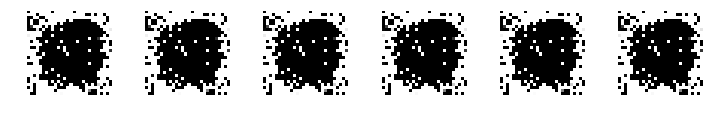

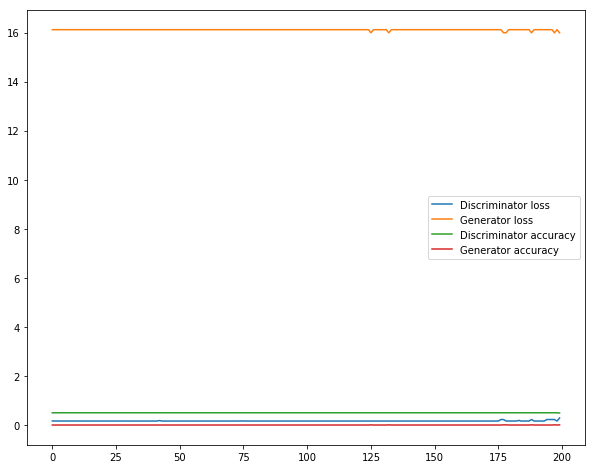

In [11]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)